In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
df=pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Data/final_dataset.csv')

In [4]:
df.sample(5)

,id,paper id,title,categories,type,content,question
53216,53216,2502.00867,partitions of an eulerian digraph into circuits,['math.co'],definitions,[Partition Lattice]\r\nLet $\mathcal{A}$ be a ...,What is the relationship between the refinemen...
41436,41436,2501.15784,constructing stable hilbert bundles via diopha...,"['math.dg', 'math-ph', 'math.ag', 'math.mp']",corollaries,"For $i=0,1$, we have $L_i(\theta)\geq 1$, and ...",Is it possible for $L_i(\theta)$ to be greater...
61254,61254,2502.04123,localizing invariants of inverse limits,"['math.kt', 'math.ag', 'math.at', 'math.ct', '...",propositions,\label{prop:Ind_and_Calk_of_ML} Let $(\cC_n)$ ...,What is the relationship between the strong Mi...
36828,36828,2501.14069,bounded toeplitz products on the hardy space,['math.fa'],definitions,"\label{ATP}\n We say $u \in H(\mathbb{T}), ...",Does the definition of an admissible Toeplitz ...
26721,26721,2501.10495,cohomology and deformations of nonabelian embe...,['math.ra'],propositions,\label{prop:nonabelian hemisemidirect product}...,Does the nonabelian hemisemidirect product 3-L...


In [ ]:
df_queries_1 = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Query_Creation/Results/queries_chunk_1.csv')
df_queries_2 = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Query_Creation/Results/queries_chunk_2.csv')
df_queries_3 = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Query_Creation/Results/queries_chunk_3.csv')
df_queries_4 = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Query_Creation/Results/queries_chunk_4.csv')
df_queries_5 = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Query_Creation/Results/queries_chunk_5.csv')
df_queries_6 = pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Query_Creation/Results/queries_chunk_6.csv')

In [ ]:
df = pd.concat([
    df_queries_1,
    df_queries_2,
    df_queries_3,
    df_queries_4,
    df_queries_5,
    df_queries_6
], ignore_index=True)
print(df.shape)
print(f"All papers are in order: {df['paper id'].is_monotonic_increasing}")
df.head()

(100000, 7)
All papers are in order: True


,id,paper id,title,categories,type,content,question
0,0,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,\label{thm:main}\n\t\nConsider any Kac-Moody L...,What is the relationship between the modified ...
1,1,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,\label{thm:my refined}\n\nLet $\fg$ be of fini...,<<SYS>>
2,2,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,\label{thm:toroidal}\n\nFor a polynomial $\ell...,What is the formula for the q-characteized val...
3,3,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,\label{thm:simple}\n\n(\cite{HJ}) Up to isomor...,Is the simple representation generated by a si...
4,4,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,\label{thm:quantum to shuffle}\n\nWe have $\em...,Is the isomorphism $\Upsilon^+$ between the sm...


Great, let's now start the post processing. We will inspect the df to find formatting failures and obvious semantic errors that we can eliminate before moving on to fine tuning.

In [ ]:
df.isna().sum()

,0
id,0
paper id,0
title,0
categories,0
type,0
content,0
question,0


In [ ]:
value_counts = df['question'].value_counts()
error= 100 * (value_counts[value_counts > 1].sum()/df.shape[0])
print(f"Total count of generated questions that are repeated more than once: {value_counts[value_counts > 1].sum()}. This accounts for {round(error, 2)}% of the dataset")
value_counts.head(50)


Total count of generated questions that are repeated more than once: 7980. This accounts for 7.98% of the dataset


,count
question,
<<SYS>>,4214
[INST],172
{,132
.,58
Here is the JSON object with the question:,40
"Here is the JSON object with one key ""questions"" whose value is a list containing one string:",40
"• Use clear, graduate-level mathematical language.",35
<</SYS>>,34
Here is the JSON object with the question that could be answered by citing this theorem:,31


From this sample it is clear that these questions repeated multiple times come from a failure and thus will be eliminated from the df. We can start by safely eliminating those questions that contain very obvious signs of failure, coming from tokens used in the system prompt of the query generator (eg. NEVER; ALWAYS; JSON; SYS; INST, etc.)

We also delete the over repeated questions, that also come from failures

In [ ]:
df_json= df[ df['question'].str.contains('JSON')]
print(f"Total number of questions with the word 'JSON' in it: {len(df_json)}")

Total number of questions with the word 'JSON' in it: 1222


In [ ]:
drop_mask = df['question'].str.contains(r'\b(?:NEVER|ALWAYS|JSON|SYS|INST)\b', na=False, regex=True)

print(f"Dropping {drop_mask.sum()} rows containing obvious signs of failure")

# Keep everything else
df = df[~drop_mask].reset_index(drop=True)

Dropping 5678 rows containing obvious signs of failure


In [ ]:
# 1) Compute how often each question appears
vc = df['question'].value_counts()

# 2) Identify questions appearing more than 5 times
too_frequent = vc[vc > 5].index

print(f"Dropping {vc[vc > 5].sum()} rows for {len(too_frequent)} over-repeated questions")

# 3) Filter them out
df = df[~df['question'].isin(too_frequent)].reset_index(drop=True)

Dropping 947 rows for 72 over-repeated questions


## Duplicated questions

Let's investigate the questions that are duplicated

In [ ]:
duplicates = value_counts[value_counts == 2]
print(f"Total amount of questions generated exactly 2 times: {len(duplicates)}")
duplicates.head(20)

Total amount of questions generated exactly 2 times: 564


,count
question,
Is there an $\epsilon$-balanced code in $\Sigma_1^n$ that can be encoded in linear time with a redundancy of $O(1)$ symbols for any $\epsilon\ge 0.1$?,2
Is the statement of theorem \ref{K4_tail} true for $\ell = 4$?,2
What is the significance of the vanishing composition in Theorem \ref{prop:chiralunit} for the induced map on the homotopy groups of the unit circle and the circle?,2
Is the homomorphism $\Sch_{\Fl}: \bigwedge_1 \otimes_\ZZ \bigwedge_2 \to \HH^*\Fl$ surjective?,2
Is the commutativity of the given diagram a consequence of the canonical isomorphism of $\mathcal{D}_{\overline{\Sigma}^3}$-modules?,2
"Does the theorem imply that if $(z- \zeta)^n u(z)$ is increasing on $B_{\epsilon}(\zeta) \cap \mathbb{T}$ as you approach $\zeta$, then $(z- \zeta)^n u(z)$ must be unbounded?",2
Is the dimension of a graph with two connected components both equal to 1?,2
Is a lexicographic extension of a Euclidean oriented matroid always Euclidean?,2
"Does the given inequality hold for all $t\in (0, a_1\rho^\beta]$?",2


Let's explore the statements behind these duplicated queries. Perhaps we find that they come from the same papers (hence we can keep them) or are just poorly generated due to a very low temperature.

In [ ]:
#  Filter the dfe down to just the duplicated questions
dup = value_counts[value_counts == 2].index
duplicates = df[df['question'].isin(dup)].copy()

# 3) Select only the columns you care about and sort for easy scanning
dup = duplicates[['paper id','type','content','question', 'categories']]

# 4) Group them by question so you can see each “cluster”
i=0
for q, group in dup.groupby('question'):
    print("-" * 80)
    print(f"QUESTION (x{len(group)}): {q}\n")
    print(group[['paper id','type', 'categories','content']].to_string(index=False))
    print()
    i+=1
    if i==20:
      break

--------------------------------------------------------------------------------
QUESTION (x2): )$, we have

  paper id     type      categories                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Looking over the results, we can observe that most of the insightful duplicated questions come from different statements that belong to the same paper. Rather than concerning, these examples are actually favorable to our model, as they help in embedding similarly statements that belong to the same paper.

Now we repeat the duplicates insight, for questions repeated 3 times.

In [ ]:

#  Filter the dfe down to just the triplicated questions
trip = value_counts[value_counts == 3].index
triplicates = df[df['question'].isin(trip)].copy()

# 3) Select only the columns you care about and sort for easy scanning
trip = triplicates[['paper id','type','content','question', 'categories']]

# 4) Group them by question so you can see each “cluster”
i=0
for q, group in trip.groupby('question'):
    print("-" * 80)
    print(f"QUESTION (x{len(group)}): {q}\n")
    print(group[['paper id','type', 'categories','content']].to_string(index=False))
    print()
    i+=1
    if i==20:
      break

--------------------------------------------------------------------------------
QUESTION (x3): $

  paper id         type                      categories                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Eliminate unwanted duplicates

In [ ]:
# 1) Compute counts and select questions appearing exactly 2 or 3 times
vc = df['question'].value_counts()
two_or_three = vc[vc.isin([2,3])].index
l=len(df)
# 2) From those, find which actually come from multiple papers
multi_paper_qs = []
for q in two_or_three:
    papers = df.loc[df['question'] == q, 'paper id'].unique()
    if len(papers) > 1:
        multi_paper_qs.append(q)

# 3) Build a new DataFrame with those multi‐paper duplicates removed
df = df[~df['question'].isin(multi_paper_qs)].reset_index(drop=True)

print(f"Dropped {l - len(df)} rows for {len(multi_paper_qs)} multi‐paper questions.")

Dropped 339 rows for 157 multi‐paper questions.


Let's now move on to more checks to find errors in our generated questions

In [ ]:
# How many end with “?” ?
ends_q = df['question'].str.strip().str.endswith('?').mean()
print(f"{ends_q*100:.1f}% of queries end with a question mark")

# Distribution of question lengths
lengths = df['question'].str.len()
print(lengths.describe())

# Flag very short (<20 chars) or very long (>200 chars) queries
print("\nToo short:", (lengths < 20).sum())
print("Example of a suspiciously short question:")
print(df[df['question'].str.len() < 20]['question'].sample(1, random_state=42).iloc[0])
print("\nToo long: ", (lengths > 200).sum())
print(df[df['question'].str.len() > 200]['question'].sample(1, random_state=42).iloc[0])


97.2% of queries end with a question mark
count    93036.000000
mean       135.062395
std         50.973538
min          1.000000
25%        100.000000
50%        130.000000
75%        165.000000
max        774.000000
Name: question, dtype: float64

Too short: 521
Example of a suspiciously short question:
=

Too long:  9547
What is the relationship between the maximal function $M_\alpha^{\rho,\theta}$ and the weights $(\mu,\nu)$ in the characterization of the weak type $(p,q)$, $\alpha$-th weak type, and critical radius $\rho$?


In [ ]:
df[df['question'].str.len() < 20]['question'].sample(10)

,question
20625,orem:
79095,level vertices.
82528,\eps
20024,_F I_\psi.$}
51701,)\begin{cases}
48563,\infty}
45448,geq m \:.
63899,.12}\\
45516,).
48022,eq:approxId}. Then


In [ ]:
print(f"Dropping {(lengths < 20).sum()} rows with very short questions")
df = df[lengths > 20].reset_index(drop=True)

Dropping 521 rows with very short questions


We observe than slightly above 90% of our questions end with a question mark. This does not mean that we should automatically discard the rest, as some of the generated questions are something like "i want to know ...." or "help me understand..."

By looking at a few samples of extremely short and long questions, we conclude that those too long do not necessarilly mean that they were incorrectly generated, but those too short usually are a product of a failure.

Let's also check for queries whose JSON failed

In [ ]:
failed_json= df[ df['question'].str.contains('question')]
print(f"Total number of questions with the word 'question' in it: {len(failed_json)}")
failed_json.sample(10)

Total number of questions with the word 'question' in it: 100


,id,paper id,title,categories,type,content,question
17575,322,2501.06684,on the speed of coming down from infinity for ...,math.pr,theorems,\label{PropC2}\nSuppose that $\mathbf{m}_{\rm...,Does the theorem imply that the limit in quest...
66990,764,2502.05146,torsion pairs and 3-fold flops,math.ag math.rt,lemmas,\label{lem:everyskyscraperistorsion}\n If \...,"{ ""questions"": [""What is the cohomological deg..."
27630,210,2501.10331,almost global existence for the stochastic nav...,math.pr math.ap,theorems,[Global solution with small noise and initial ...,"{""questions"": [""Is the existence of a unique s..."
88201,12027,2502.14319,crystal structure of localized quantum unipote...,math.rt math.qa,propositions,[{\cite[Proposition 3.1.]{KKOP22}}]\label{prop...,"{""questions"": [""Is the condition $\tE_{i_\ell}..."
90079,14063,2502.15166,constructions of macaulay posets and macaulay ...,math.co math.ac,definitions,\label{defn: union simplicial order}\n\t\tLet ...,"{""questions"": [""Does the union simplicial orde..."
57237,917,2502.01424,fluid limit and gelation in the frozen erd\h{o...,math.pr,lemmas,\label{cor:edo_aleat} For $\varepsilon>0$ suff...,"{""questions"": [""Does the existence of a unique..."
14986,187,2501.05737,efficient gradient tracking algorithms for dis...,math.oc,theorems,\label{thm:x-opt-1}\r\n\tLet\r\n\t$$\alpha_k=\...,"{ ""questions"": [""What is the condition for the..."
8816,549,2501.03694,finite-sample properties of the trimmed mean,math.st math.pr stat.th,theorems,\label{thm:generalpreciseGaussian}There exists...,Here is a question that could be answered by c...
84465,7994,2502.12773,improved bounds for the coefficient of flow po...,math.co,lemmas,"(Jackson,\cite{Jackson1})\label{lem15}\r\nThe ...",Is the graph in question 3-connected?
92372,16544,2502.16046,linnik problem for maass--hecke cuspforms and ...,math.nt math.rt,propositions,\label{prop:escape}\nFix $\eta>0$ and $B>0$. ...,"{ ""questions"": [""What is the implication of Co..."


Finally, we just sample random questions, looking for any systematic pattern that can threat our model.

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df['question'].sample(50)

,question
78853,Is it possible for a fuzzy relation to be both a backward bisimulation and a backward prebisimulation between two fuzzy Kripke models?
34367,Does Conjecture~\ref{MDS conjecture unitary} imply Conjecture~\ref{Recipe conjecture unitary} with a power-saving error term?
78874,"Does the theorem imply that there is at most one $\overline{T}_\beta$-orbit closure contained in $I$ for any $I=[t,t+\frac{1}{\beta}]\subset [0,1]$ and any $\beta>1$?"
10396,What is the definition of a completely $\gamma$-invariant subset in the context of an iterated function system on a topological space?
37198,"What is the relationship between the Loewy length of an $R$-module $M$ with respect to the maximal ideal $I$ of a local ring $R$, and the minimal number of generators of $M$ as an $R$-module?"
50613,Does the uniqueness of the modulation parameter $g$ in the given theorem imply that the value of $g$ at any time $t \ge T_0$ is uniquely determined by the value of $g$ at $T_0$?
72412,What is the relationship between the Chern number $c_1^2$ and the holomorphic Euler characteristic $\chi_h$ in terms of the signature $\sigma$ of a closed 4-manifold $X$?
11934,Does the theorem imply that the norm of the parameter vector is bounded by a constant M0?
57950,What is the relationship between the limit superior of the directional derivative of the norm of a Banach space and the subdifferential of the norm function?
7513,Is $\texttt{IL}$ complete over $\Vdash$?


We pick up on another pattern. Those questions that contain 'given theorem', were generated from a point of view in which the person already knew about the theorem. We are not interested in that because those queries offer low semantic overlap with the statement they belong to, acting as some sort of noise signal.

In [ ]:
df_theo= df[ df['question'].str.contains('given theorem')]
print(f"Total number of questions with 'given theorem' in it: {len(df_theo)}")
df_theo.sample(5)

Total number of questions with 'given theorem' in it: 3714


,id,paper id,title,categories,type,content,question
64590,163,2502.04297,statistical guarantees for continuous-time policy evaluation: blessing of ellipticity and new tradeoffs,cs.lg math.oc math.pr math.st stat.th,propositions,"[\cite{wang2005character}, Proposition 1.2]\label{prop:semigroup-grad-estimate-local-grow}\n Under above setup, for any bounded Lipschitz function $u$ on $\real^\usedim$ and $t > 0$, we have\n \begin{align*}\n \vecnorm{\nabla \semigroup_t u (x)}{2}^2 \leq e^{2 c t} \semigroup_t \Big( \vecnorm{\nabla u }{2}^2 \Big) (x), \quad \mbox{for any $x \in \StateSpace$},\n \end{align*}\n for any constant $c$ satisfying\n \begin{align*}\n c \geq \frac{1}{\lammin} \sup_{x \in \real^\usedim} \Big\{ \sum_{i, j \in [\usedim]} \vecnorm{\nabla \covMat_{i,j} (x)}{2}^2 + \opnorm{\nabla \cdot \drift (x)}^2 \Big\}.\n \end{align*}",Does the given theorem imply that the gradient of the semigroup estimate is bounded by a function of the gradient of the original function?
65907,588,2502.04861,optimal low degree hardness for broadcasting on trees,math.pr,lemmas,"\label{lem PT NormConversion}\n The following holds for sufficiently large \(\tCR\):\n suppose \(u \in V(T)\) satisfies \(\lA{u} \ge \hB\). \n Then, for every \(f \in \F{\Dm{u}} \otimes \T{\Dm{u}}\),\n \begin{align}\label{eq PT NormConversion}\n (1-\kappa)\,\Tnorm{f}{u}\n \;\;\le\;\;\n \Unorm{f}{u}\n \;\;\le\;\;\n (1+\kappa)\,\Tnorm{f}{u}.\n \end{align}",What is the relationship between the \(\Tnorm\) and \(\Unorm\) of a function \(f\) and the norm of the vector \(u\) in the context of the given theorem?
74090,428,2502.08304,on euler-sombor energy of graphs,math.co,theorems,"Let $P_{n}$ be a path with order $n\geq 4$ ,then it's Euler Sombor energy is given by \r\n\begin{align*}\r\n\ E_{ES}(P_{n}) \leq \sqrt{12}{E(P_{n})+2(\sqrt{7}-\sqrt{12})}.\r\n\end{align*}","What is the relationship between the Euler Sombor energy and the energy of a path $P_{n}$, as stated in the given theorem?"
24562,871,2501.09011,quantum cohomology and floer invariants of semiprojective toric manifolds,math.sg math.ag,theorems,"The $d_{j}^{p}$ and $f_j^p$ \r\nare finite invariants, and they satisfy the following properties:\r\n\begin{align*}\r\n0\leq d_j^{p} \leq \dim_{\k}H^*(Y),\r\n\qquad\quad\r\nd_j^p \leq d_{j}^{p'} \;&\textrm{ for }\; p\leq p', \qquad\quad\r\nd_j^p \geq d_{j+1}^p,\r\n\\\r\nf_j^p = \#\{\textrm{invariant factors }u^j\textrm{ of } E^-c_{p^+}\}, \r\n\qquad\r\n &\textrm{ and } \qquad\r\nd_j^p = \#\{\textrm{invariant factors }u^{\geq j}\textrm{ of } E^-c_{p^+}\}.\r\n\end{align*}\r\nIn particular, $f_p$ is always a polynomial, and $s_p$ is a polynomial precisely when $E^-c_{p^+}$ is injective.","What is the relationship between the $d_j^p$ and $f_j^p$ invariants, as described by the given theorem?"
86456,10145,2502.13583,fundamental bias in inverting random sampling matrices with application to sub-sampled newton,math.na cs.na math.oc stat.ml,lemmas,"[Row norms]\label{lemm: HD_balance_row_norms} \nLet $\H_n\in \RR^{n \times n}$ be the Walsh--Hadamard matrix of size $n\geq 4$ as in~\Cref{def:srht} and $\D_n =\diag(\bupsilon)\in \RR^{n \times n}$ with $\bupsilon \in \RR^{n}$ a Rademacher random vector.\nThen, we have, for a matrix $\X\in\RR^{n\times d}$ with $n\geq d$ and $ t\geq \max\{\|\X\X^\top\|_F\sqrt{\log(2n/\delta)/(cn^2)},\|\X\|^2\log(2n/\delta)/(cn)\}$ that\n\begin{align*}\n \Pr\left( \left|\frac{\|\ee_i^\top\H_n\D_n\X\|^2}{n}-\frac{\|\X\|_F^2}{n} \right|\geq t,1\leq i\leq n\right)\leq \delta,\n\end{align*}\nwhere $\|\cdot\|_F$ denotes the Frobenius norm, and $c>0$ is a universal constant.","Does the given theorem imply that the expected value of the squared row norms of the product of the Walsh-Hadamard matrix, the diagonal matrix with Rademacher random vector, and any $n\times d$ matrix is equal to the squared Frobenius norm of the latter matrix?"


In [ ]:
df=df[~df['question'].str.contains(' given theorem')].reset_index(drop=True)

Let's take a look at the final shape and distribution of the dataset

In [ ]:
print(f"final df shape: {df.shape}")
print(f"All papers are in order: {df['paper id'].is_monotonic_increasing}")

final df shape: (88775, 7)
All papers are in order: True


In [ ]:
gb = df.groupby('paper id').size()
gb.describe()

,0
count,4843.000000
mean,18.330580
std,18.050687
min,1.000000
25%,7.000000
50%,13.000000
75%,23.000000
max,255.000000



Filtered distribution:
count    4795.000000
mean       17.314286
std        14.642260
min         1.000000
25%         7.000000
50%        13.000000
75%        23.000000
max        89.000000
dtype: float64


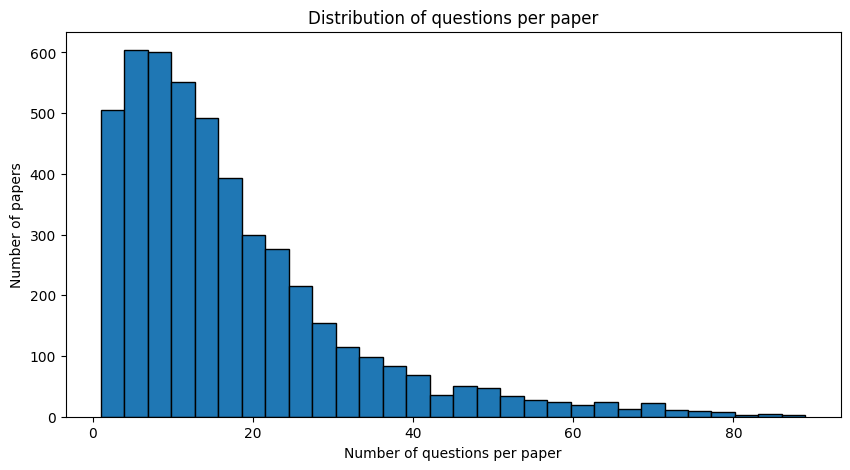

In [ ]:
cutoff=gb.quantile(0.99)
gb_filtered= gb[gb<=cutoff]
print("\nFiltered distribution:")
print(gb_filtered.describe())

plt.figure(figsize=(10,5))
plt.hist(gb_filtered, bins=30, edgecolor='black')
plt.xlabel('Number of questions per paper')
plt.ylabel('Number of papers')
plt.title('Distribution of questions per paper')

plt.show()

In [ ]:
df.reset_index(drop=True, inplace=True)
df['id']=df.index
df.head()

,id,paper id,title,categories,type,content,question
0,0,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,"\label{thm:main}\n\t\nConsider any Kac-Moody Lie algebra $\fg$ and any rational $\ell$-weight $\bpsi$. For any $\by \in (\BC^*)^{\bm}$ and $\bn \geq \bm$, we let $\bx = (\by,\b0_{\bn-\bm}) \in \BC^{\bn}$ and we claim that\n\t\begin{equation}\n\t\t\label{eqn:intro factor}\n\t\t\omu_{\bx}^{\bpsi} = \omu_{\by}^{\bpsi} \onu^{\eord\bpsi}_{\bn - \bm}\n\t\end{equation}\n\twith $\onu^{\eord \bpsi}_{\bn - \bm}$ as in \eqref{eqn:multiplicity nu}. In other words, the modified $q$-character factors as\n\t\begin{equation}\n\t\t\label{eqn:intro factor series}\n\t\t\chi_q(\oL(\bpsi)) = \chi^{\neq 0}_q(\oL(\bpsi)) \cdot \ochi^{\eord \bpsi}\n\t\end{equation}\n\twhere $\chi^{\neq 0}_q(\oL(\bpsi))$ is the RHS of \eqref{eqn:intro q-character variant} with $\sum_{\bx \in (\BC^*)^{\bn}}$ instead of $\sum_{\bx \in \BC^{\bn}}$, and\n\begin{equation}\n\t\t\t\label{eqn:intro ochi integral}\n\t\t\t\ochi^{\br} = \sum_{\bn \in \nn} \onu^{\br}_{\bn} [-\bn]\n\t\t\end{equation}\n\tfor all $\br \in \zz$, where $[-\bn]$ is interpreted as a constant $\ell$-weight, see Definition \ref{def:ell weight general}.",What is the relationship between the modified $q$-character factors and the multiplicity functions in the Kac-Moody Lie algebra $\fg$?
1,1,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,"\label{thm:toroidal}\n\nFor a polynomial $\ell$-weight $\btau$ as in \eqref{eqn:intro integral toroidal}, we have\n\begin{equation}\n\label{eqn:tau q-char intro}\n\chi_{q}^{\emph{ref}}(L(\btau)) = [\btau] \prod_{n=1}^{\infty} \prod_{d=1}^{rn} \frac 1{1-h^n v^d}\n\end{equation}\nMoreover, we give analogues of formulas \eqref{eqn:act 1 intro}-\eqref{eqn:act 3 intro}, see \eqref{eqn:act tor 1}-\eqref{eqn:act tor 3}.",What is the formula for the q-characteized value of the toroidal weight polynomial $L(\btau)$?
2,2,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,"\label{thm:simple}\n\n(\cite{HJ}) Up to isomorphism, there is a unique simple representation \n$$\n\UUaffg \curvearrowright L(\bpsi)\n$$\ngenerated by a single vector $\vac$ that satisfies the identities\n$$\ne_{i,d}\cdot \vac= 0\n$$\n$$\n\ph^+_{i}(z)\cdot \vac = \psi_i(z)\vac\n$$\nfor all $i \in I$, $d \geq 0$. This representation is in category $\CO$ if and only if $\bpsi$ is rational.","Is the simple representation generated by a single vector $\vac$ that satisfies the identities $e_{i,d}\cdot \vac= 0$ and $\ph^+_{i}(z)\cdot \vac = \psi_i(z)\vac$ for all $i \in I$, $d \geq 0$ necessarily in category $\CO$ if $\bpsi$ is rational?"
3,3,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,"\label{thm:quantum to shuffle}\n\nWe have $\emph{Ker }\widetilde{\Upsilon}^+ = I^+$ of \eqref{eqn:kernel 1}, so $\widetilde{\Upsilon}^+$ induces an isomorphism\n\begin{equation}\n\label{eqn:upsilon plus}\n\Upsilon^+ : \UUp \xrightarrow{\sim} \CS^+\n\end{equation}\nwhere the \textbf{(small) shuffle algebra} is defined as $\CS^+ = \emph{Im }\widetilde{\Upsilon}^+ \subseteq \CV$.",Is the isomorphism $\Upsilon^+$ between the small shuffle algebra $\CS^+$ and the convex hull $\CV$ of the unit vector $\UUp$ induced by the map $\widetilde{\Upsilon}^+$ an isomorphism?
4,4,2501.00724,category o for quantum loop algebras,math.rt math.qa,theorems,"\label{thm:is rational} \n\nA simple module $\CA^\geq \curvearrowright L({\bpsi})$ is in category $\CO$ if and only if $\bpsi$ is rational, in the sense of Definition \ref{def:ell weight general}.",Is a simple module $\CA^\geq \curvearrowright L({\bpsi})$ in category $\CO$ necessarily equivalent to $\bpsi$ being rational?


In [ ]:
df['categories'] = df['categories'].str.split()

In [ ]:
# Explode the list of categories into individual rows
cat_counts = df['categories'].explode().value_counts().reset_index()
cat_counts.columns = ['category', 'count']

# View the top categories
print(cat_counts.head(20))

# Or see the full distribution
print(f"Total unique categories: {len(cat_counts)}")
print(cat_counts.to_string(index=False))

   category  count
0   math.co  12498
1   math.ap  11058
2   math.ag   9838
3   math.pr   9541
4   math.nt   6574
5   math.oc   6463
6   math.mp   6371
7   math-ph   6371
8   math.ds   5884
9   math.dg   5545
10  math.fa   5339
11  math.rt   5117
12  math.gr   4038
13  math.lo   3868
14  math.gt   3744
15  math.ca   3685
16  math.it   3540
17    cs.it   3540
18    cs.lg   3479
19  math.na   3459
Total unique categories: 123
          category  count
           math.co  12498
           math.ap  11058
           math.ag   9838
           math.pr   9541
           math.nt   6574
           math.oc   6463
           math.mp   6371
           math-ph   6371
           math.ds   5884
           math.dg   5545
           math.fa   5339
           math.rt   5117
           math.gr   4038
           math.lo   3868
           math.gt   3744
           math.ca   3685
           math.it   3540
             cs.it   3540
             cs.lg   3479
           math.na   3459
             cs.na   3459


In [ ]:
# check out the coverage for the most common categories
selected_cats = [
    'math.co', 'math.ap', 'math.ag', 'math.pr', 'math.nt', 'math.oc', 'math.mp',
    'math-ph', 'math.ds', 'math.dg', 'math.fa', 'math.rt', 'math.gr', 'math.lo',
    'math.gt', 'math.ca', 'math.it', 'cs.it', 'cs.lg', 'math.na', 'cs.na',
    'math.at', 'stat.th', 'math.st', 'math.ra', 'math.ct', 'stat.ml',
    'math.qa', 'math.ac', 'math.oa', 'math.mg', 'math.cv', 'math.sp'
]

# Mark rows that belong to any of these categories
df['in_selected'] = df['categories'].apply(lambda cats: any(c in selected_cats for c in cats))

# Count distinct papers in and out of this set
total_papers    = df['paper id'].nunique()
covered_papers  = df.loc[df['in_selected'], 'paper id'].nunique()

print(f"Total unique papers:             {total_papers}")
print(f"Papers in selected categories:   {covered_papers}")
print(f"Coverage of selected set:        {covered_papers/total_papers:.1%}")

Total unique papers:             4843
Papers in selected categories:   4794
Coverage of selected set:        99.0%


In [ ]:
df.drop(columns=['is_top20', 'in_selected'], inplace=True)

In [ ]:
df.to_csv('/content/drive/Shareddrives/Master_Thesis/Query_Creation/Results/final_dataset.csv', index=False)

In [ ]:
df.to_csv('/content/drive/Shareddrives/Master_Thesis/Data/final_dataset.csv', index=False)

In [ ]:
df=pd.read_csv('/content/drive/Shareddrives/Master_Thesis/Data/test.csv')

In [ ]:
df.head()

,id,paper id,title,categories,type,content,question
0,28,2501.00724,category o for quantum loop algebras,"['math.rt', 'math.qa']",definitions,\label{def:q-character}\n\n(\cite{FR}) The $q$...,What is the $q$-character of the representatio...
1,55,2501.00728,high-probability polynomial-time complexity of...,['math.oc'],lemmas,\label{lm:bound_of_kappaBinvA}\n\tFor any $t >...,What is the probability that the condition $\k...
2,60,2501.00728,high-probability polynomial-time complexity of...,['math.oc'],lemmas,[Lemma 3.6 of \citet{xiong2024accessible}]\lab...,What is the expression for $Q_{\bar{\Theta}}^{...
3,66,2501.00728,high-probability polynomial-time complexity of...,['math.oc'],corollaries,\label{cor:complexity-random}\n\tLet $C_3 > 1$...,Does the probabilistic model with rPDHG achiev...
4,74,2501.00728,high-probability polynomial-time complexity of...,['math.oc'],definitions,[$\eps$-optimal solutions]\n\tThe pair of prim...,What does it mean for a pair of primal-dual so...


In [ ]:
import random
# Step 1: Get unique paper IDs
paper_ids = df['paper id'].unique()

# Step 2: Select a random paper ID
random_paper_id = random.choice(paper_ids)

# Step 3: Filter the DataFrame for that paper
paper_df = df[df['paper id'] == random_paper_id]

# Step 4: Randomly sample two statements from that paper
sampled_statements = paper_df.sample(n=2, random_state=42)  # set random_state for reproducibility

# Step 5: Print or return them
print(f"Selected paper ID: {random_paper_id}")
sampled_statements[['id', 'type', 'content', 'question']]

Selected paper ID: 2501.09266


,id,type,content,question
2439,24087,corollaries,\label{cor:lipschitz}\n For $\delta$ suffic...,Is the Lipschitz constant of a bi-Lipschitz ma...
2433,24031,theorems,[{\cite[Theorem 1.1]{HM2023}}]\label{thm:HM}\n...,Does the theorem imply that the support of $X_...
